<a href="https://colab.research.google.com/github/sharmin133/Rice-Leaf/blob/main/Grad_CAM_with_VGG16_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
input_shape=(96, 96, 3)

In [ ]:
image_dir = Path('/content/drive/MyDrive/Final Thesis/preprocessing/resize dataset')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)


image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [ ]:

image_df = image_df.sample(frac=1).reset_index(drop = True)
image_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/Final Thesis/preprocess...,_Healthy
1,/content/drive/MyDrive/Final Thesis/preprocess...,_Healthy
2,/content/drive/MyDrive/Final Thesis/preprocess...,_Healthy
3,/content/drive/MyDrive/Final Thesis/preprocess...,Bacterialblight
4,/content/drive/MyDrive/Final Thesis/preprocess...,Blast


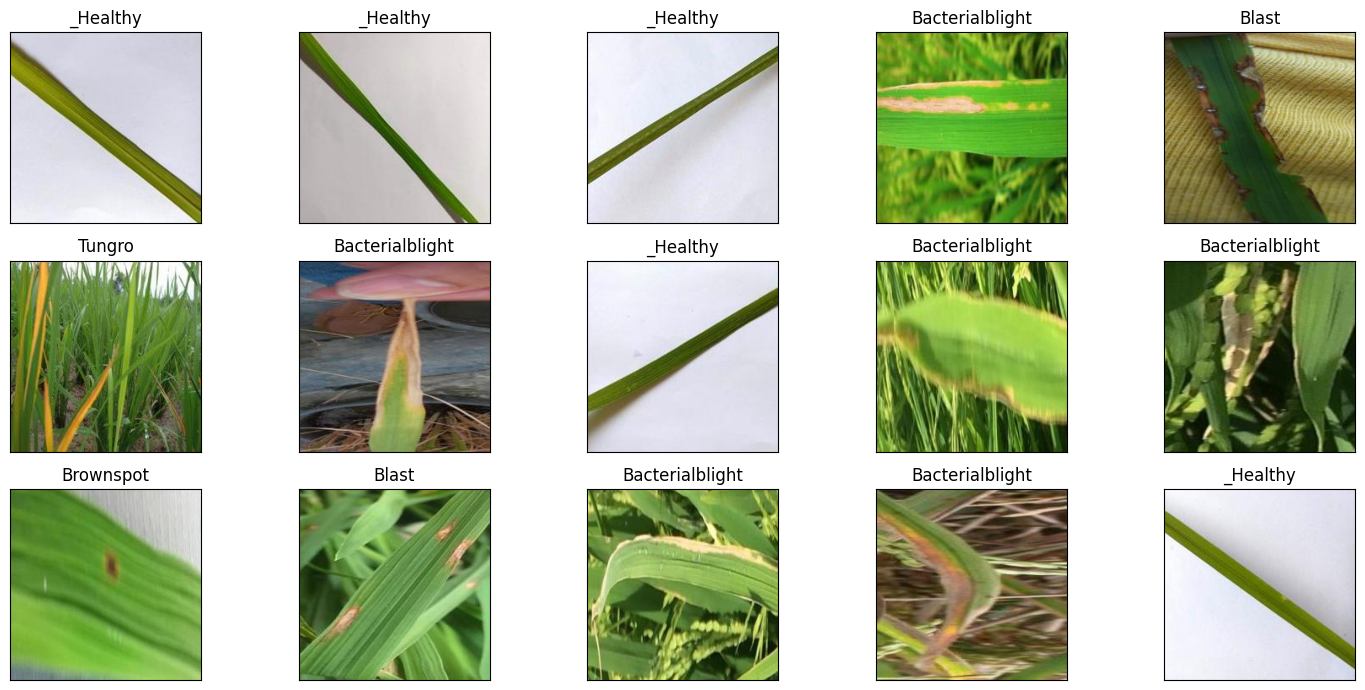

In [ ]:

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.1
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(96, 96),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(96,96),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(96,96),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4145 validated image filenames belonging to 5 classes.
Found 460 validated image filenames belonging to 5 classes.
Found 1152 validated image filenames belonging to 5 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
# Load the pretrained VGG16 model
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False,
    input_shape=(96, 96, 3),pooling='avg'

)

# Set the pretrained model's layers to non-trainable
pretrained_model.trainable = False


In [ ]:
# Assuming 'model' is your TensorFlow model
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)


x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    verbose=1,
        )

Epoch 1/25
130/130 [==============================] - 1045s 8s/step - loss: 4.5642 - accuracy: 0.5785 - val_loss: 2.6345 - val_accuracy: 0.8804
Epoch 2/25
130/130 [==============================] - 465s 4s/step - loss: 2.7010 - accuracy: 0.7764 - val_loss: 2.0868 - val_accuracy: 0.9457
Epoch 3/25
130/130 [==============================] - 458s 4s/step - loss: 2.0823 - accuracy: 0.8632 - val_loss: 1.6748 - val_accuracy: 0.9652
Epoch 4/25
130/130 [==============================] - 498s 4s/step - loss: 1.6628 - accuracy: 0.9071 - val_loss: 1.3647 - val_accuracy: 0.9674
Epoch 5/25
130/130 [==============================] - 497s 4s/step - loss: 1.3612 - accuracy: 0.9267 - val_loss: 1.1145 - val_accuracy: 0.9848
Epoch 6/25
130/130 [==============================] - 494s 4s/step - loss: 1.1004 - accuracy: 0.9486 - val_loss: 0.9241 - val_accuracy: 0.9804
Epoch 7/25
130/130 [==============================] - 454s 3s/step - loss: 0.9181 - accuracy: 0.9568 - val_loss: 0.7660 - val_accuracy: 0.991

In [ ]:
for layer in model.layers:
    print(layer.name)

input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d_1
dense_25
dropout_12
dense_26
dropout_13
dense_27


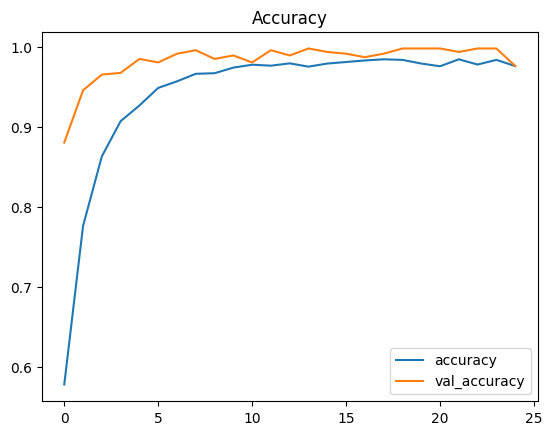

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

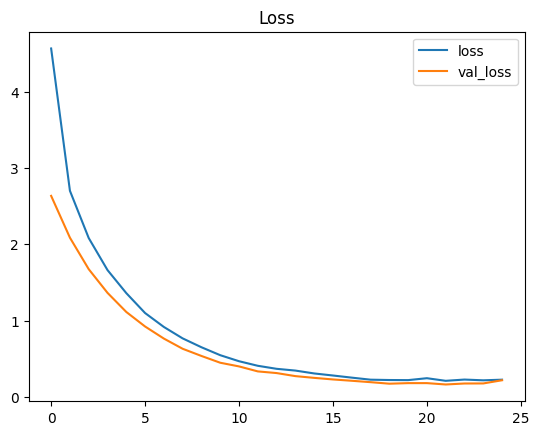

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:

pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(f'The first 5 predictions: {pred[:5]}')

36/36 [==============================] - 308s 9s/step
The first 5 predictions: ['_Healthy', 'Brownspot', 'Bacterialblight', 'Brownspot', '_Healthy']


In [ ]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

Bacterialblight       0.96      1.00      0.98       259
          Blast       0.99      0.97      0.98       195
      Brownspot       1.00      0.98      0.99       330
         Tungro       1.00      1.00      1.00        75
       _Healthy       1.00      1.00      1.00       293

       accuracy                           0.99      1152
      macro avg       0.99      0.99      0.99      1152
   weighted avg       0.99      0.99      0.99      1152



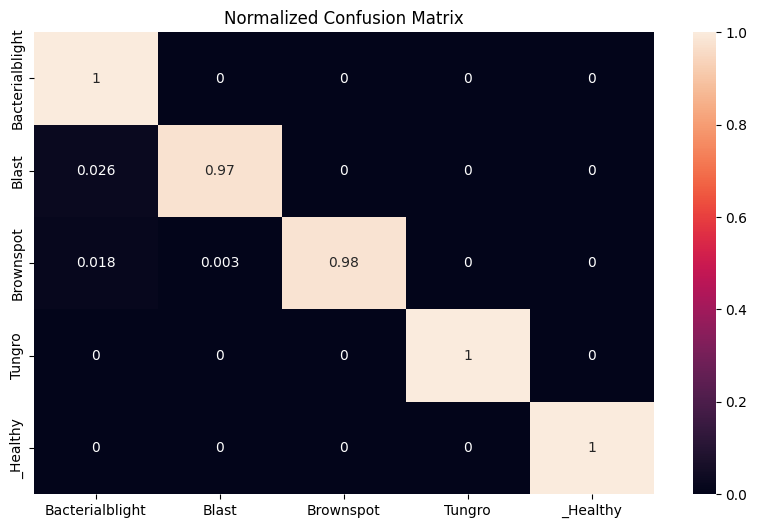

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

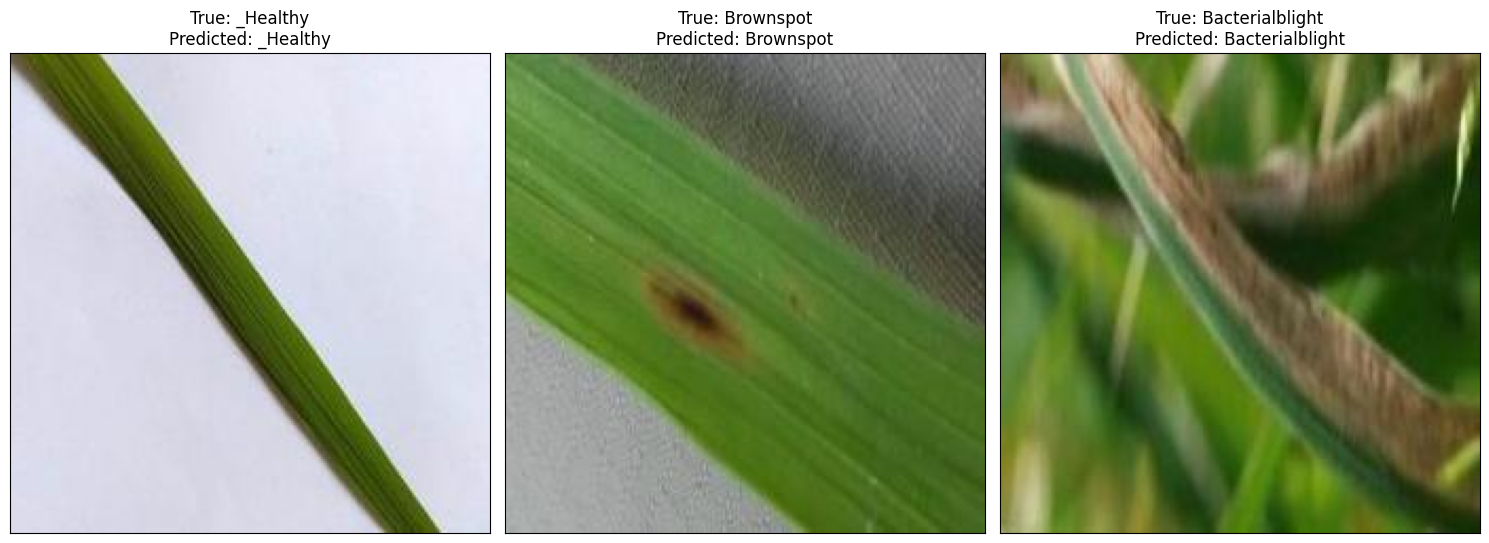

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(test_df):
        ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
        ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)

    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )


    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    grads = tape.gradient(class_channel, last_conv_layer_output)


    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)


    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):

    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)


    heatmap = np.uint8(255 * heatmap)


    jet = cm.get_cmap("jet")


    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]


    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)


    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)


    superimposed_img.save(cam_path)



    return cam_path

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "block5_conv3"
img_size = (96,96)

model.layers[-1].activation = None

<ipython-input-45-741510581261>:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


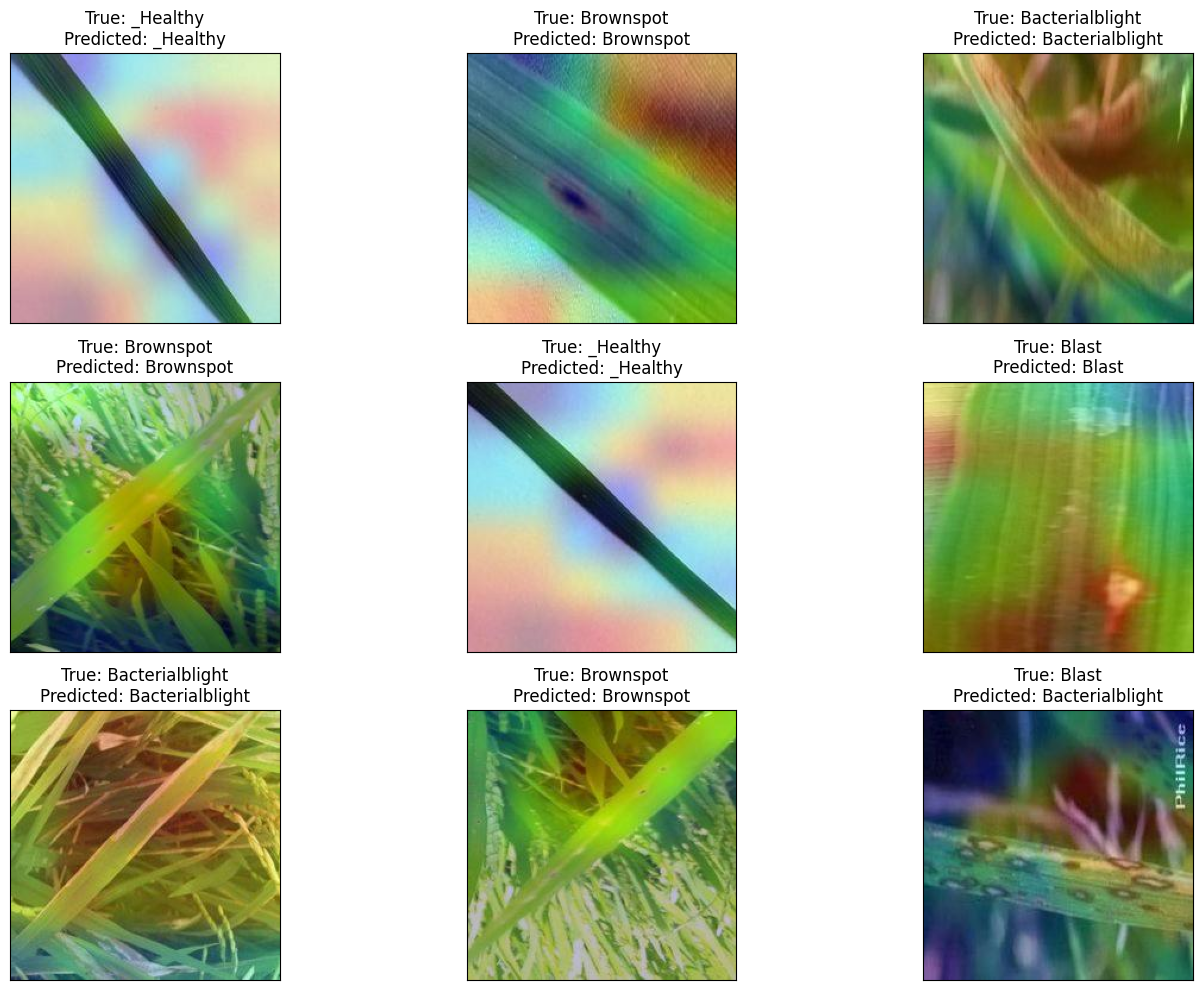

In [ ]:

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()